In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [44]:
from scipy.ndimage import gaussian_filter

def random_field(N=256, k_P=-1, sigma=10, seed=None):
    if seed is not None:
        np.random.seed(seed)

    f = np.random.normal(size=[N, N])
    F = np.fft.fftn(f)
    k = np.fft.fftfreq(N, 1./(2*np.pi))[np.indices(f.shape)]
    k_abs = np.sqrt((k**2).sum(axis=0))
    
    with np.errstate(divide='ignore'):
        q = k_abs**k_P * np.exp(-k_abs**2 * sigma**2)
    q[0, 0] = 1.0
    F *= q
    return fft.ifftn(F).real

def blob(N=256, r=64, sigma=10):
    x = np.indices([N, N]) - N/2
    f = (x**2).sum(axis=0) < r**2
    return gaussian_filter(f.astype('float'), sigma)

In [45]:
field = blob(sigma=10) + random_field(sigma=1) * 0.1
smooth_field = gaussian_filter(field, 10, mode='wrap')

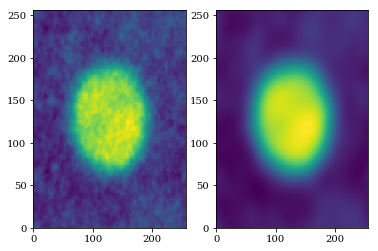

In [46]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.pcolormesh(field)
ax = fig.add_subplot(122)
ax.pcolormesh(smooth_field)
plt.show()

In [47]:
from scipy.ndimage import sobel
from hyper_canny import cp_edge_thinning

In [48]:
sb = np.zeros((3,) + field.shape)
sobel(smooth_field, axis=0, mode='wrap', output=sb[0])
sobel(smooth_field, axis=1, mode='wrap', output=sb[1])

with np.errstate(divide='ignore', invalid='ignore'):
    sb[2] = 1./np.sqrt(sb[0]**2 + sb[1]**2)
    sb[0] *= sb[2]
    sb[1] *= sb[2]
data = sb.astype('float32').transpose([2,1,0]).copy()
mask = cp_edge_thinning(data)
edges = mask.transpose([1, 0])

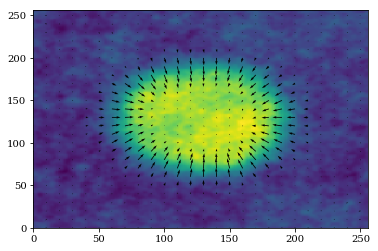

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.pcolormesh(field)
# ax.pcolormesh(edges)
dx = sb[0]/sb[2] ; dy = sb[1]/sb[2]
X = np.indices(field.shape)
ax.quiver(X[1,::10,::10], X[0,::10,::10], dy[::10,::10], dx[::10,::10], scale=8)
plt.show()

In [50]:
from hyper_canny import cp_double_threshold

In [51]:
(1./sb[2]).max()

0.25255296445120534

In [52]:
new_mask = cp_double_threshold(data, mask, 1/0.2, 1/0.1)

In [53]:
new_edges = new_mask.T

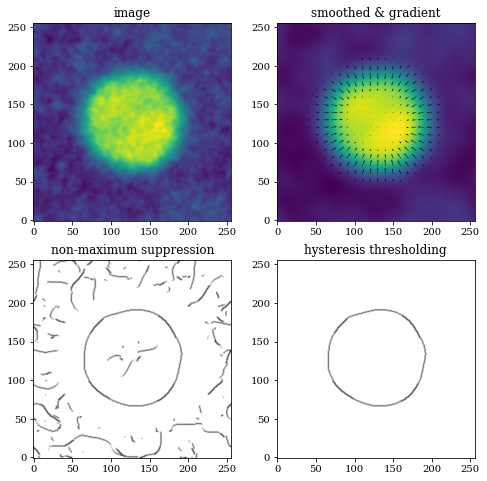

In [54]:
plt.rcParams['font.family'] = 'serif'
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(221)
ax.imshow(field, origin='lower', aspect='equal', interpolation='bicubic')
ax.set_title('image')
ax = fig.add_subplot(222)
ax.imshow(smooth_field, origin='lower', aspect='equal', interpolation='bicubic')
dx = sb[0]/sb[2] ; dy = sb[1]/sb[2]
X = np.indices(field.shape)
ax.quiver(X[1,::10,::10], X[0,::10,::10], dy[::10,::10], dx[::10,::10], scale=7)
ax.set_title('smoothed & gradient')
ax = fig.add_subplot(223)
ax.imshow(edges, origin='lower', aspect='equal', cmap='binary', interpolation='bicubic')
ax.set_title('non-maximum suppression')
ax = fig.add_subplot(224)
# ax.pcolormesh(field)
ax.imshow(new_edges, origin='lower', aspect='equal', cmap='binary', interpolation='bicubic')
ax.set_title('hysteresis thresholding')
#dx = sb[0]/sb[2] ; dy = sb[1]/sb[2]
#X = np.indices(field.shape)
plt.savefig('canny4.pdf', format='pdf', bbox_inches='tight')
plt.show()